# Explorig the effects of zeros in OscoNet


In [1]:
%matplotlib inline
from OscopeBootstrap import qvalue
from OscopeBootstrap.create_edge_network_represention import create_edge_network_representation
from OscopeBootstrap.SyntheticDataset import GetSimISyntheticData, true_adj_matrix
from OscopeBootstrap.oscope_tf import bootstrap_hypothesis_test, get_accuracy, get_metrics_for_different_qvalue_thresholds
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple



In [2]:
def GetSimZeros(NG: int = 15, G: int = 1000, N: int = 100, noiseLevel: int = 0,a: float =0.05, ngroups: int = 3) \
        -> Tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    sigma_strLevel = [0.05, 0.1, 0.2, 0.3, 0.4, 0.6]
    sigma_str = sigma_strLevel[noiseLevel]

    data = np.zeros((G, N))
    data[:] = np.nan
    # genes per weak/strong oscillatory group
    # Group 1
    cellName = []
    for i in range(N):
        cellName.append('C'+str(i))

    geneName = []

    phaseG = np.zeros((G))
    angularSpeed = np.zeros((G))
    #a=0.01#percentage of zeros desired. Setting for No zero inflation is a=0.05, l=0.1
    l=0.1
    nn=round(a*N)
    mm1=round((N-nn)/2)
    if  ((nn % 2) == 0):
        mm2=mm1
    else:
        mm2=mm1+1
    #to do:half this and the other half use alexis procedure
    nz=round(NG/2)
    for i in range(nz):  # strong oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        ml=3/2*np.pi-startingPhase
        t0 = np.linspace( ml-l, ml+l,nn)   
        t1b0=np.linspace( 0, ml-l,mm1)
        t1a0=np.linspace( ml+l,2*np.pi,mm2)
        t1=np.concatenate((t1b0, t0,t1a0), axis=None)
        t1=np.concatenate((t1, t1+2*np.pi), axis=None)
        t1s=np.sort(t1)
        t1sub=t1s[range(0, 2*N-1, 2)]
         

        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(t1sub + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    for i in range(nz, NG):  # strong oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + sigma_str*np.random.randn(N)
        geneName.append('G1SO'+str(i))
    for i in range(NG, NG+nz):  # weak oscillators with zeros
        startingPhase = np.random.uniform(0, 2*np.pi)
        
        ml=3/2*np.pi-startingPhase
        t0 = np.linspace( ml-l, ml+l,nn)   
        t1b0=np.linspace( 0, ml-l,mm1)
        t1a0=np.linspace( ml+l,2*np.pi,mm2)
        t1=np.concatenate((t1b0, t0,t1a0), axis=None)
        t1=np.concatenate((t1, t1+2*np.pi), axis=None)
        t1s=np.sort(t1)
        t1sub=t1s[range(0, 2*N-1, 2)]
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(t1sub + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    for i in range(NG+nz, 2*NG):  # weak oscillators without zeros
        t1 = np.linspace(0, 2*np.pi, N)
        startingPhase = np.random.uniform(0, 2*np.pi)
        phaseG[i] = startingPhase
        angularSpeed[i] = 2
        data[i, :] = np.sin(2*t1 + startingPhase) + 2*sigma_str*np.random.randn(N)
        geneName.append('G1WO'+str(i))
    if(ngroups >= 2):
        # Group 2
        t2=np.linspace(0, 2*np.pi, N)
        for i in range(2*NG, 2*NG+nz):  # strong oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) 
            geneName.append('G2SO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i,:]= data[i,:] + sigma_str*np.random.randn(N)
        for i in range(2*NG+nz, 3*NG):  # strong oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + sigma_str*np.random.randn(N)
            geneName.append('G2SO'+str(i))
        for i in range(3*NG, 3*NG+nz):  # weak oscillators with zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase)
            geneName.append('G2WO'+str(i))
            j0=np.random.randint(N-1, size=nn)
            data[i,j0]=-1
            data[i, :] = data[i, :] + 2*sigma_str*np.random.randn(N)
        for i in range(3*NG+nz, 4*NG):  # weak oscillators without zeros
            startingPhase = np.random.uniform(0, 2*np.pi)
            phaseG[i] = startingPhase
            angularSpeed[i] = 3
            data[i, :] = np.sin(3*t2 + startingPhase) + 2*sigma_str*np.random.randn(N)
            geneName.append('G2WO'+str(i))
  # white noise genes
    for w in range(i+1, G):  # use i index from above where it stopped
        phaseG[w] = np.nan
        angularSpeed[w] = np.nan
        data[w, :] = np.max([3/2 * sigma_str, 1]) * np.random.randn(N)
        geneName.append('R'+str(w))
    assert np.all(~ np.isnan(data)), 'Entries with nans!'
    assert len(geneName) == G
    assert len(cellName) == N
    df = pd.DataFrame(data, index=geneName, columns=cellName)
    return df, phaseG, angularSpeed




In [54]:
data = np.zeros((G, N))
data[:] = np.nan
a=0
nn=round(a*N)
l=0.1
startingPhase = np.random.uniform(0, 2*np.pi)
j0=np.random.randint(N-1, size=nn)
data[i,j0]=-1


### Create a synthetic dataset containing one group of co-oscillating genes and vary the percentage of zeros in the original data (this corresponds to the number of -1 in the sinusoidal data)

/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


find_best_psi_for_each_gene_pair 3 secs
get_permuted_cost 6 secs
get_pvalues 0 secs
qvalues pi0=1.016, estimated proportion of null features 
got pi0 > 1 (1.016) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.97
True positive rate 0.97, False discovery rate 0.19


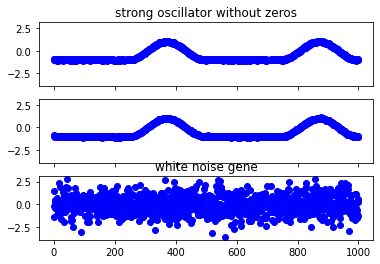

In [3]:
NG = 10  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 80  # number of genes
N = 1000 # cells
ngroups = 2 # num of cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
a=[0] #[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.08,0.09,0.1,0.2,0.3,0.5,0.6,0.7,0.8,0.9,1]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))

for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=0,a=a[i], ngroups= ngroups)
    adjacency_matrix_true = true_adj_matrix(G, angularSpeed)  # True adjacency matrix
    adjacency_matrix, qvalues, cost_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator with zeros')
    ax[1].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator without zeros')
    ax[2].plot(np.arange(N), data_df.iloc[4*NG, :], 'bo'); ax[2].set_title('white noise gene')

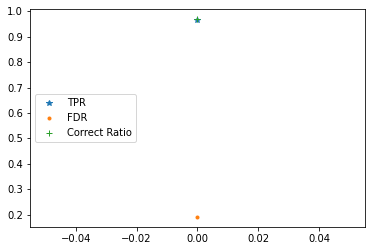

In [4]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');
plt.legend(loc='center left', frameon=True)


In [5]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [0.96578947]
FDR= [0.19162996]
correct_ratio= [0.96835443]


Text(0.5, 1.0, 'estimated adjacency matrix')

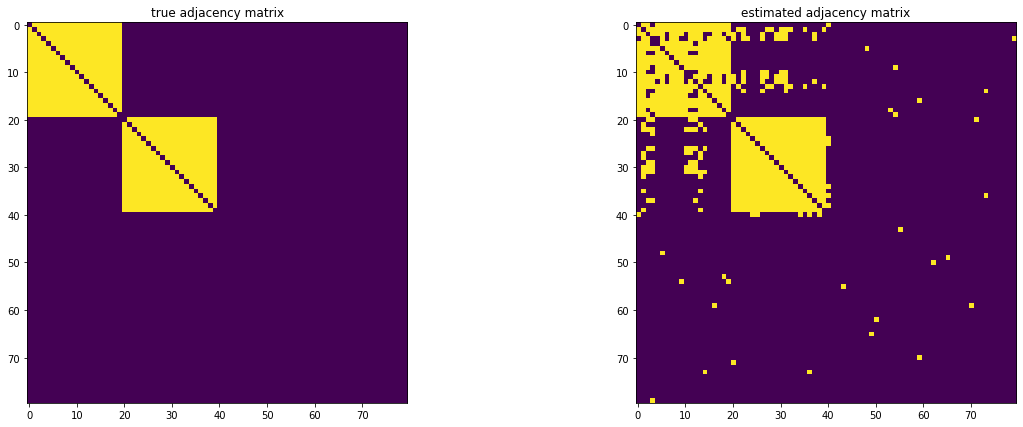

In [45]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].imshow(adjacency_matrix_true); ax[0].set_title('true adjacency matrix')
ax[1].imshow(adjacency_matrix); ax[1].set_title('estimated adjacency matrix')

In [662]:
# considering a -1,1 conversion the zeros (min) will go towars -1 . Consider [min,-0.985] as 0 range
#np.shape(np.where(x<-0.985))[1] #number of zeros if uniformly sampled in N=1000 cells are ~55 so ~5%
#we could increse the observations in [min,-0.985] to see the effects of zeros. This means that instead of:
#    t1 = np.linspace(0, 2*np.pi, N)
# we could use more dense sampling around 3/2*np.pi:
#a=0.001#percentage of zeros desired
#nn=round(a*N)
#t0 = np.linspace( 3/2*np.pi-0.2, 3/2*np.pi+0.2,nn)
#mm=round((1-a)*N/2)
#t1b0=np.linspace( 0, 3/2*np.pi-0.2,mm)
#t1a0=np.linspace( 3/2*np.pi+0.2,2*np.pi,mm)
#t1=np.concatenate((t1b0, t0,t1a0), axis=None)
#t1.shape

# Consider now only high percentage of zeros

find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.100, estimated proportion of null features 
got pi0 > 1 (1.100) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.96
True positive rate 0.87, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.813, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 0.93, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.909, estimated proportion of null features 
Ratio of correctly identified pairs 0.91
True positive rate 0.67, False discovery rate 0.06
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.244, estimated proportion of null features 
got pi0 > 1 (1.244) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.98
True positive rate 0.96, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.005, estimated proportion of null features 
got pi0 > 1 (1.005) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.97
True positive rate 0.91, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.861, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.96, False discovery rate 0.00
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.574, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.04
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.861, estimated proportion of null features 
Ratio of correctly identified pairs 0.98
True positive rate 1.00, False discovery rate 0.08
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.383, estimated proportion of null features 
Ratio of correctly identified pairs 0.97
True positive rate 0.93, False discovery rate 0.05
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.766, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 0.98, False discovery rate 0.00
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.813, estimated proportion of null features 
Ratio of correctly identified pairs 0.99
True positive rate 1.00, False discovery rate 0.02
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=0.335, estimated proportion of null features 
Ratio of correctly identified pairs 0.97
True positive rate 0.98, False discovery rate 0.10
find_best_psi_for_each_gene_pair 0 secs


/Users/luisacutillo/GitProjects/Elli/FullOscoNet/OscopeBootstrap/oscope_tf.py:222: RuntimeWarning: invalid value encountered in multiply
  psi_ng = np.zeros((G, G)) * np.inf


get_permuted_cost 0 secs
get_pvalues 0 secs
qvalues pi0=1.100, estimated proportion of null features 
got pi0 > 1 (1.100) while estimating qvalues, setting it to 1
Ratio of correctly identified pairs 0.76
True positive rate 0.00, False discovery rate 1.00


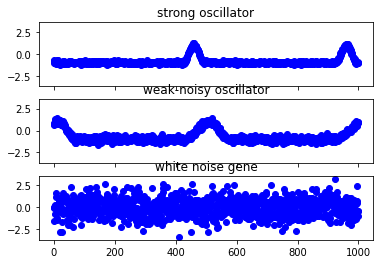

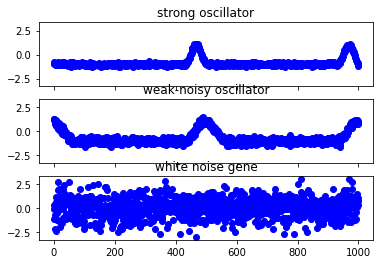

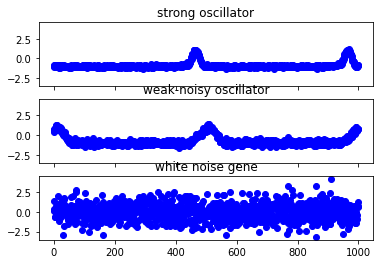

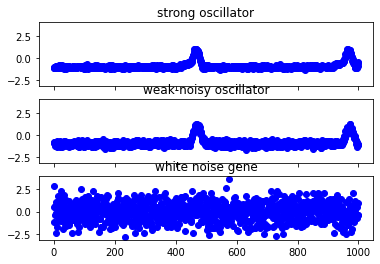

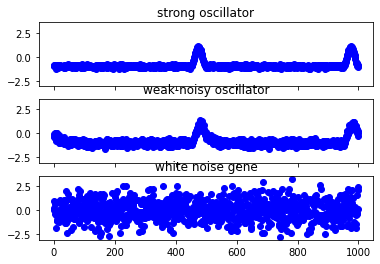

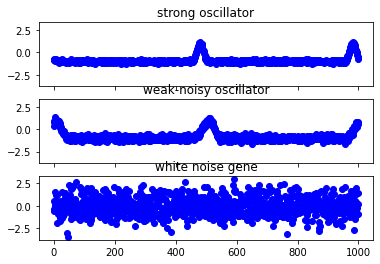

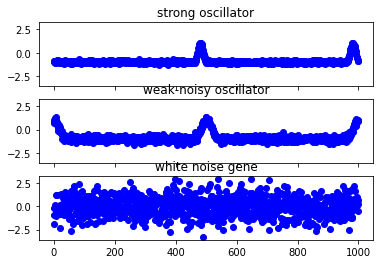

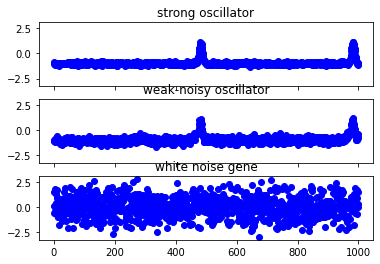

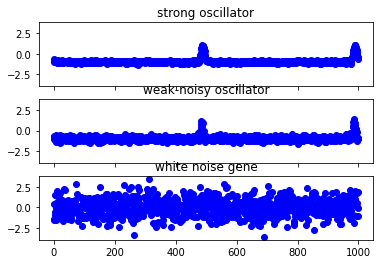

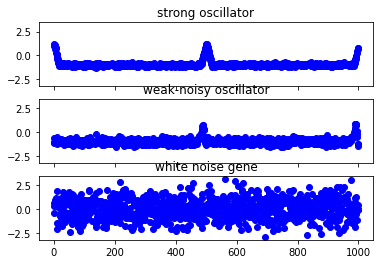

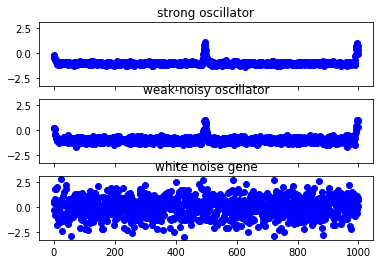

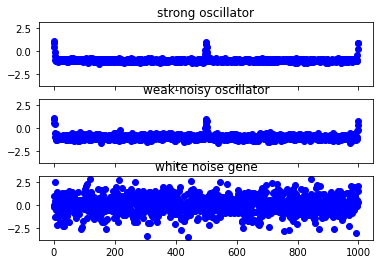

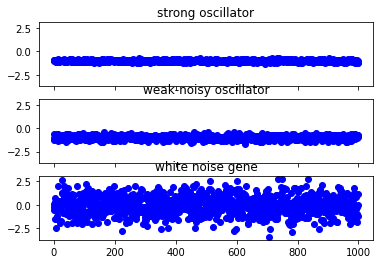

In [663]:
NG = 5  # half gene cluster size so we have a total of 10 co-oscillating genes  
G = 20  # number of genes
N = 1000 # cells
#ngroups = 1 # one cluster
n_bootstrap = 100  # number of bootstrap samples
grid_points_in_search = 10  # grid size for phase shift parameter estimation., 
alpha = 0.001  # significance level
a=[0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,1]
correct_ratio = np.zeros(len(a))
TPR = np.zeros(len(a))
FDR = np.zeros(len(a))

for i in range(len(a)):
    data_df, phaseG, angularSpeed = GetSimZeros(NG=NG, G=G, N=N, noiseLevel=1,a=a[i])
    adjacency_matrix, qvalues, cost_matrix = bootstrap_hypothesis_test(n_bootstrap, data_df.values, alpha=alpha,
                                                            grid_points_in_search=grid_points_in_search)
    correct_ratio[i] = get_accuracy(adjacency_matrix, adjacency_matrix_true)
    print(f'Ratio of correctly identified pairs {correct_ratio[i]:.2f}')
    TPR[i], FDR[i], _ = get_metrics_for_different_qvalue_thresholds(qvalues, adjacency_matrix_true, np.array([alpha]))
    print(f'True positive rate {float(TPR[i]):.2f}, False discovery rate {float(FDR[i]):.2f}')
    _, ax = plt.subplots(3, sharex=True, sharey=True)
    ax[0].plot(np.arange(N), data_df.iloc[0, :], 'bo'); ax[0].set_title('strong oscillator')
    ax[1].plot(np.arange(N), data_df.iloc[0+NG, :], 'bo'); ax[1].set_title('weak-noisy oscillator')
    ax[2].plot(np.arange(N), data_df.iloc[2*NG, :], 'bo'); ax[2].set_title('white noise gene')

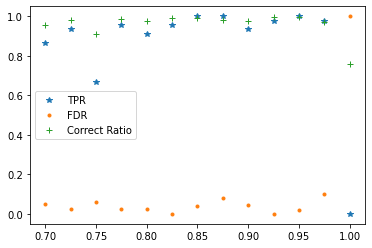

In [664]:
plt.plot(a,TPR,'*',label='TPR')
plt.plot(a,FDR,'.',label='FDR')
plt.plot(a,correct_ratio,'+',label='Correct Ratio');
plt.legend(loc='center left', frameon=True)


In [665]:
print('TPR=',TPR)
print('FDR=',FDR)
print('correct_ratio=',correct_ratio)

TPR= [0.86666667 0.93333333 0.66666667 0.95555556 0.91111111 0.95555556
 1.         1.         0.93333333 0.97777778 1.         0.97777778
 0.        ]
FDR= [0.04878049 0.02325581 0.0625     0.02272727 0.02380952 0.
 0.04255319 0.08163265 0.04545455 0.         0.02173913 0.10204082
 1.        ]
correct_ratio= [0.95789474 0.97894737 0.91052632 0.98421053 0.97368421 0.98947368
 0.98947368 0.97894737 0.97368421 0.99473684 0.99473684 0.96842105
 0.75789474]
